In [1]:
from brian2 import *
%matplotlib inline

#### Single Synapse Toy Network
The purpose of this notebook is to illustrate the impact of different synaptic spike timing on weight changes in a Spiking Neural Network with the Spike Time Dependent Plasticity learning paradigm. Below is a brief explanation of the mechanics of the STDP paradigm.

#### Spike Time Dependent Plasticity learning
The method aims to tackle network learning by defining synaptic weights based on the timing difference between pre- and post-synaptic responses. Each synapse keeps a set of two variables: $a_{pre}$ and $a_{post}$ 

These variables are exponentially decaying traces of recent spike activity. Their decay is modelled via the following differential equations:

$\frac{d a_{pre}}{dt} = - \frac{a_{pre}}{\tau_{pre}}$ \
$\frac{d a_{post}}{dt} = - \frac{a_{post}}{\tau_{post}}$ \
Where $\tau_{pre}$ and $\tau_{post}$ are time constants that control the speed of the decay of the trace

The solution to the differential equation is:

$a_{pre}(t) = A_{pre} e^{-(t-t_0)/\tau_{pre}}$ \
| Where $A_{pre}$ defines the intial increase of the trace variable $a$ everytime a spike occurs

And similarly for $a_{post}$

In [2]:
# Here we define a simple toy network with 2 LIF neurons and 1 synapse connection between them

taupre = taupost = 20*ms
wmax = 0.01
Apre = 0.01 
Apost = -Apre * taupre/taupost * 1.05 # Note we increase the affect of decreasing the weights by a factor of 1.05 to avoid the values of the weights blowing up due to noise or other correlations

G = NeuronGroup(2,
                '''
                v : 1
                t_spike : second
                ''',
                threshold='t > t_spike',
                refractory=100*ms)

G.t_spike[0] = 10*ms
G.t_spike[1] = 20*ms
# Importantly, the value of v in these neuron's aren't defined by the equation typical of say LIF neurons, the neurons in this case are just spike generators, and do not have the behaivour of rising and falling values of V

S = Synapses(G, G,
        '''
        w : 1
        dapre/dt = -apre/taupre : 1 (clock-driven)
        dapost/dt = -apost/taupost : 1 (clock-driven)
        ''', 
        on_pre='''
        v_post += w
        apre += Apre
        w = clip(w+apost, 0, wmax)
        ''',
        on_post='''
        apost += Apost
        w = clip(w+apre, 0, wmax)
        ''', method='linear')
# Note in the synapse definition, we say that the evolution of the spike traces happen WITH the clock (clock-driven). This is for illustrative purposes in the upcoming graphs and figures, in practice you would use (event-driven) instead since it is fair more efficient

S.connect(i=0, j=1) # Connecting Neuron 0 to neuron 1 makes neuron 0 the presynaptic neuron and neuron 1 the postsynaptic neuron
# And since we defined neuron 0 to have a threshold of 10ms and neuron 1 to have a threshold of 20ms, this example will yield in a presynaptic neuron fire followed by postsynaptic neuron fire with 10ms of time difference (relatively small) 

M = StateMonitor(S, ['w', 'apre', 'apost'], record=True)

run(30*ms)

Note that we defined the behavior of the pre- and post-synaptic responses as follows:

On pre-synapse spike:
* $a_{pre}$ is increased by $A_{pre}$ either a lot or a little (depending on synaptic spike order) before decaying
* $w$ += $a_{post}$

On post-synapse spike:
* $a_{post}$ is descreased by $A_{post}$ either a lot or a little (depending on synaptic spike order) before decaying
* $w$ += $a_{pre}$

Next we will explain the 4 cases for the different orders of synaptic firing and time difference between them

#### Case 1: Presynaptic fire SHORTLY BEFORE Postsynaptic fire
According to the behaivor we defined above, this should result in a large increase in the weight value of the synapse, we'll have to redefine the neuron group and synapse to follow each case (which it already does in this case, but we'll redefine it anyway)

Mathematically, this should be defined as:

Pre fires: 
* $a_{pre}$ += $A_{pre} \to a_{pre} = 0.01$
* $w$ += $a_{post}$ (since $a_{post} ≈ 0$, no real weight is added)

5 ms Pass (Calculate $a_{pre}$ when post spike occurs as: $a_{pre} ≈ 0.01 * e^{-5/20}$ which is much larger since 5ms is small relative to 20ms) 

Post fires: 
* $a_{post}$ += $A_{post}$ ($A_{post}$ becomes negative)
* $w$ += $a_{pre}$ ($w$ increases significantly!)

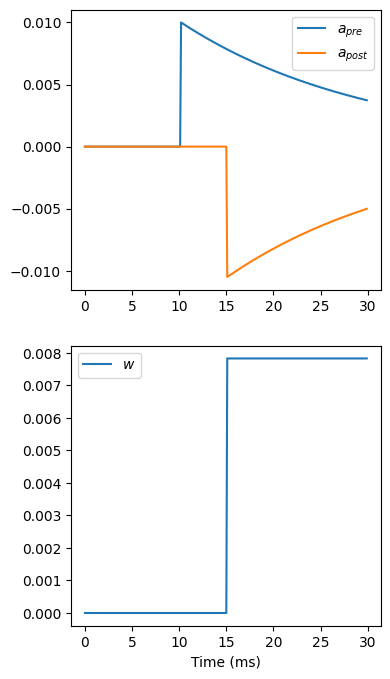

In [3]:
start_scope()

G = NeuronGroup(2,
                '''
                v : 1
                t_spike : second
                ''',
                threshold='t > t_spike',
                refractory=100*ms)

G.t_spike[0] = 10*ms
G.t_spike[1] = 15*ms

S = Synapses(G, G,
        '''
        w : 1
        dapre/dt = -apre/taupre : 1 (clock-driven)
        dapost/dt = -apost/taupost : 1 (clock-driven)
        ''', 
        on_pre='''
        v_post += w
        apre += Apre
        w = clip(w+apost, 0, wmax)
        ''',
        on_post='''
        apost += Apost
        w = clip(w+apre, 0, wmax)
        ''', method='linear')

S.connect(i=0, j=1)

M = StateMonitor(S, ['w', 'apre', 'apost'], record=True)

run(30*ms)

figure(figsize=(4, 8))
subplot(211)
plot(M.t/ms, M.apre[0], label='$a_{pre}$')
plot(M.t/ms, M.apost[0], label='$a_{post}$')
legend()
subplot(212)
plot(M.t/ms, M.w[0], label='$w$')
legend()
xlabel('Time (ms)');

This matches our expectation!

#### Case 2: Presynaptic fire LONG BEFORE Postsynaptic fire

Mathematically, this should be defined as:

Pre fires: 
* $a_{pre}$ += $A_{pre} \to a_{pre} = 0.01$
* $w$ += $a_{post}$ (since $a_{post} ≈ 0$, no real weight is added)

50 ms Pass (Calculate $a_{pre}$ when post spike occurs as: $a_{pre} ≈ 0.01 * e^{-50/20}$ which is much smaller since 50ms is large relative to 20ms) 

Post fires: 
* $a_{post}$ += $A_{post}$
* $w$ += $a_{pre}$ ($w$ increases very slightly!)

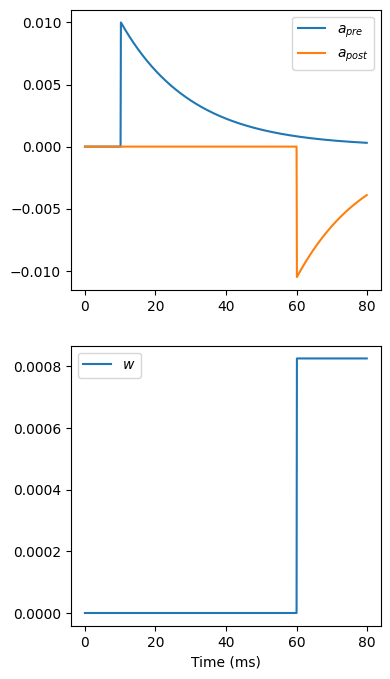

In [7]:
start_scope()

G = NeuronGroup(2,
                '''
                v : 1
                t_spike : second
                ''',
                threshold='t > t_spike',
                refractory=100*ms)

G.t_spike[0] = 10*ms
G.t_spike[1] = 60*ms

S = Synapses(G, G,
        '''
        w : 1
        dapre/dt = -apre/taupre : 1 (clock-driven)
        dapost/dt = -apost/taupost : 1 (clock-driven)
        ''', 
        on_pre='''
        v_post += w
        apre += Apre
        w = clip(w+apost, 0, wmax)
        ''',
        on_post='''
        apost += Apost
        w = clip(w+apre, 0, wmax)
        ''', method='linear')

S.connect(i=0, j=1)

M = StateMonitor(S, ['w', 'apre', 'apost'], record=True)

run(80*ms)

figure(figsize=(4, 8))
subplot(211)
plot(M.t/ms, M.apre[0], label='$a_{pre}$')
plot(M.t/ms, M.apost[0], label='$a_{post}$')
legend()
subplot(212)
plot(M.t/ms, M.w[0], label='$w$')
legend()
xlabel('Time (ms)');

This matches our expectation!

#### Case 3: Presynaptic fire SHORTLY AFTER Postsynaptic fire

Mathematically, this should be defined as:

Post fires: 
* $a_{post}$ += $A_{post}$ ($a_{post}$ becomes negative)
* $w$ += $a_{pre}$ (roughly no change in w) 

5 ms Pass (Calculate $a_{post}$ when pre spike occurs as: $a_{post} ≈ -0.0105 * e^{-5/20}$ which is strongly negative) 

Pre fires: 
* $a_{pre}$ += $A_{pre}$
* $w$ += $a_{post}$ ($w$ decreases significantly!)

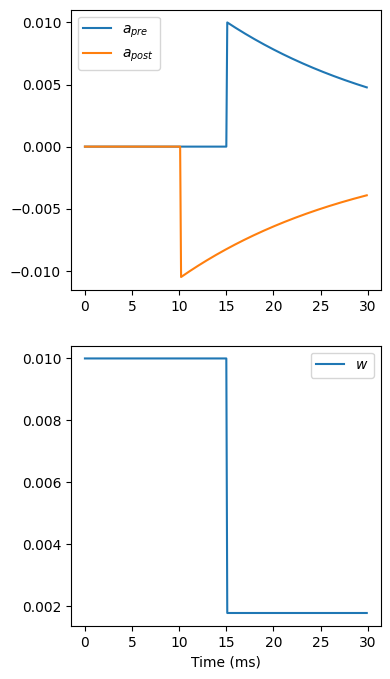

In [18]:
start_scope()

G = NeuronGroup(2,
                '''
                v : 1
                t_spike : second
                ''',
                threshold='t > t_spike',
                refractory=100*ms)

G.t_spike[0] = 15*ms
G.t_spike[1] = 10*ms

S = Synapses(G, G,
        '''
        w : 1
        dapre/dt = -apre/taupre : 1 (clock-driven)
        dapost/dt = -apost/taupost : 1 (clock-driven)
        ''', 
        on_pre='''
        v_post += w
        apre += Apre
        w = clip(w+apost, 0, wmax)
        ''',
        on_post='''
        apost += Apost
        w = clip(w+apre, 0, wmax)
        ''', method='linear')

S.connect(i=0, j=1)

S.w[0] = wmax # Note that for Cases 3 and 4 we give the synapse weight some base value, so we can visualise the weight decrease (since the default value of 0 wouldn't show a decrease below 0)

M = StateMonitor(S, ['w', 'apre', 'apost'], record=True)

run(30*ms)

figure(figsize=(4, 8))
subplot(211)
plot(M.t/ms, M.apre[0], label='$a_{pre}$')
plot(M.t/ms, M.apost[0], label='$a_{post}$')
legend()
subplot(212)
plot(M.t/ms, M.w[0], label='$w$')
legend()
xlabel('Time (ms)');

This matches our expectation!

#### Case 4: Presynaptic fire LONG AFTER Postsynaptic fire

Mathematically, this should be defined as:

Post fires:
* $a_{post}$ += $A_{post}$ ($a_{post}$ becomes negative)
* $w$ += $a_{pre}$ (roughly no change in w)

50 ms Pass (Calculate $a_{post}$ when pre spike occurs as: $a_{post} ≈ -0.0105 * e^{-50/20}$ which is weakly negative, ie. close to 0)

Pre fires:
* $a_{pre}$ += $A_{pre}$
* $w$ += $a_{post}$ ($w$ decreases very slightly!)

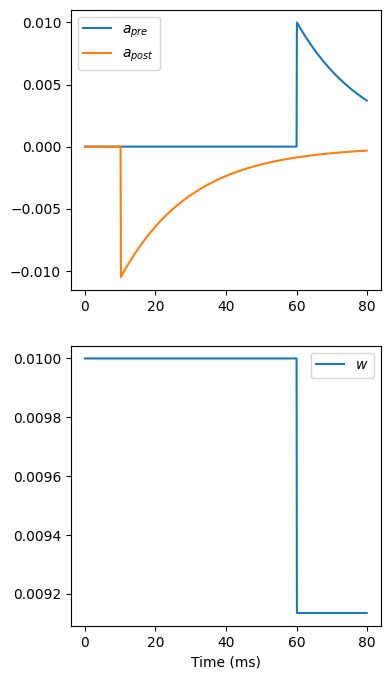

In [19]:
start_scope()

G = NeuronGroup(2,
                '''
                v : 1
                t_spike : second
                ''',
                threshold='t > t_spike',
                refractory=100*ms)

G.t_spike[0] = 60*ms
G.t_spike[1] = 10*ms

S = Synapses(G, G,
        '''
        w : 1
        dapre/dt = -apre/taupre : 1 (clock-driven)
        dapost/dt = -apost/taupost : 1 (clock-driven)
        ''', 
        on_pre='''
        v_post += w
        apre += Apre
        w = clip(w+apost, 0, wmax)
        ''',
        on_post='''
        apost += Apost
        w = clip(w+apre, 0, wmax)
        ''', method='linear')

S.connect(i=0, j=1)

S.w[0] = wmax # Note that for Cases 3 and 4 we give the synapse weight some base value, so we can visualise the weight decrease (since the default value of 0 wouldn't show a decrease below 0)

M = StateMonitor(S, ['w', 'apre', 'apost'], record=True)

run(80*ms)

figure(figsize=(4, 8))
subplot(211)
plot(M.t/ms, M.apre[0], label='$a_{pre}$')
plot(M.t/ms, M.apost[0], label='$a_{post}$')
legend()
subplot(212)
plot(M.t/ms, M.w[0], label='$w$')
legend()
xlabel('Time (ms)');

This matches our expectation!